In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten,Conv1D,MaxPooling1D,TimeDistributed
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [17]:
print(len(X_train))
print(len(X_train[0]))
print(len(X_train[0][0]))

7352
128
9


In [18]:
trainX = X_train.reshape((len(X_train), 4,32, input_dim))
testX = X_test.reshape((len(X_test), 4, 32, input_dim))

- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 34s 5ms/step - loss: 1.3306 - acc: 0.4361 - val_loss: 1.1743 - val_acc: 0.4723
Epoch 2/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.9716 - acc: 0.5788 - val_loss: 0.9656 - val_acc: 0.5263
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.7787 - acc: 0.6510 - val_loss: 0.7841 - val_acc: 0.6135
Epoch 4/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6911 - acc: 0.6587 - val_loss: 0.7109 - val_acc: 0.6203
Epoch 5/30
7352/7352 [==============================] - 26s 3ms/step - loss: 0.6496 - acc: 0.6794 - val_loss: 0.8000 - val_acc: 0.6362
Epoch 6/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.8295 - acc: 0.6221 - val_loss: 0.7970 - val_acc: 0.6318
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.5920 - acc: 0.7

In [20]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      398        66        0                   0   
STANDING                 0      100       418        2                   0   
WALKING                  0        3         0      465                   8   
WALKING_DOWNSTAIRS       0        0         0        0                 360   
WALKING_UPSTAIRS         0        3         0       23                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           27  
STANDING                          12  
WALKING                           20  
WALKING_DOWNSTAIRS                60  
WALKING_UPSTAIRS                 444  


In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 305us/step


In [22]:
score

[0.4692274864947224, 0.8805564981336953]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

## Single Layer Hyper Parameter tuning

In [19]:
np.save("./tmp/X_train", X_train)
np.save("./tmp/Y_train", Y_train)
np.save("./tmp/X_test", X_test)
np.save("./tmp/Y_test", Y_test)

In [20]:
n_classes

6

In [17]:
def data():
    x_train = np.load("./tmp/X_train.npy")
    y_train = np.load("./tmp/Y_train.npy")
    x_test = np.load("./tmp/X_test.npy")
    y_test = np.load("./tmp/Y_test.npy")
    return x_train, y_train, x_test, y_test

In [80]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# Reference - https://github.com/maxpumperla/hyperas

def create_model(x_train, y_train, x_test, y_test):
    
    epochs = 30
    batch_size = 16
    timesteps = x_train.shape[1]
    input_dim = len(x_train[0][0])
    n_classes = 6
    
    model = Sequential()
    model.add(LSTM({{choice([64, 32, 16])}}, input_shape=(timesteps, input_dim)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(n_classes, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # ... model fitting
    
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_data=(x_test, y_test))
    validation_acc = np.amax(history.history['val_acc'])
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [81]:
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=4, trials=Trials(), notebook_name = "HAR_LSTM")
score = best_model.evaluate(X_test, Y_test)


>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'LSTM': hp.choice('LSTM', [64, 32, 16]),
        'Dropout': hp.uniform('Dropout', 0, 1),
    }

>>> Data
  1: 
  2: x_train = np.load("./tmp/X_train.npy")
  3: y_train = np.load("./tmp/Y_train.npy")
  4: x_test = np.load("./tmp/X_test.npy")
  5: y_test = np.load("./tmp/Y_test.npy")
  6: 
  7: 
  8: 
>>> Resulti

 - 23s - loss: 0.5146 - acc: 0.8211 - val_loss: 0.5720 - val_acc: 0.8361      

Epoch 18/30                                                                   
 - 23s - loss: 0.5210 - acc: 0.8326 - val_loss: 0.6667 - val_acc: 0.8334      

Epoch 19/30                                                                   
 - 23s - loss: 0.4721 - acc: 0.8520 - val_loss: 0.6538 - val_acc: 0.8456      

Epoch 20/30                                                                   
 - 26s - loss: 0.4444 - acc: 0.8658 - val_loss: 0.6144 - val_acc: 0.8215      

Epoch 21/30                                                                   
 - 24s - loss: 0.4416 - acc: 0.8734 - val_loss: 0.5811 - val_acc: 0.8571      

Epoch 22/30                                                                   
 - 30s - loss: 0.4092 - acc: 0.8832 - val_loss: 0.4342 - val_acc: 0.8738      

Epoch 23/30                                                                   
 - 24s - loss: 0.3897 - acc: 0.8887 - val_loss

In [86]:
print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print(best_model.summary())
print("\n\n")

---------------------
|      Accuracy      |
---------------------
91.99%

----------------------------------
|      Best Hyper-Parameters      |
----------------------------------
{'Dropout': 0.23316134447477344, 'LSTM': 0}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None





In [88]:
from sklearn.metrics import confusion_matrix

true_values = [np.argmax(i)+1 for i in Y_test]
predicted_prob = best_model.predict(X_test)
predicted_values = [np.argmax(i)+1 for i in predicted_prob]


label = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
frame_confusion = pd.DataFrame(confusion_matrix(true_values, predicted_values), index = label, columns = label)


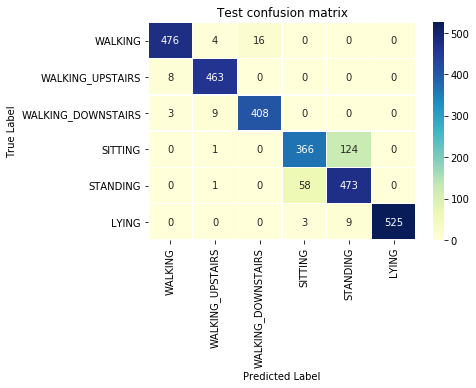

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(frame_confusion, annot = True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Test confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 2-Layer hyper parameter tuning

In [25]:
def data():
    x_train = np.load("./tmp/X_train.npy")
    y_train = np.load("./tmp/Y_train.npy")
    x_test = np.load("./tmp/X_test.npy")
    y_test = np.load("./tmp/Y_test.npy")
    return x_train, y_train, x_test, y_test

In [26]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# Reference - https://github.com/maxpumperla/hyperas

def create_model(x_train, y_train, x_test, y_test):
    
    epochs = 30
    batch_size = 16
    timesteps = x_train.shape[1]
    input_dim = len(x_train[0][0])
    n_classes = 6
    
    model = Sequential()
    model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, input_dim)))
    model.add(Dropout({{uniform(0, 1)}}))   
    model.add(LSTM({{choice([64, 32, 16])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(n_classes, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # ... model fitting
    
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_data=(x_test, y_test))
    validation_acc = np.amax(history.history['val_acc'])
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [27]:
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=4, trials=Trials(), notebook_name = "HAR_LSTM")
score = best_model.evaluate(X_test, Y_test)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pa

Train on 7352 samples, validate on 2947 samples                                
Epoch 1/30                                                                     
 - 64s - loss: 1.3529 - acc: 0.4335 - val_loss: 1.1770 - val_acc: 0.4506       

Epoch 2/30                                                                     
 - 56s - loss: 1.1150 - acc: 0.5148 - val_loss: 0.9697 - val_acc: 0.5938       

Epoch 3/30                                                                       
 - 56s - loss: 0.9493 - acc: 0.6023 - val_loss: 0.8144 - val_acc: 0.6003         

Epoch 4/30                                                                       
 - 56s - loss: 0.9392 - acc: 0.5913 - val_loss: 0.8347 - val_acc: 0.6040         

Epoch 5/30                                                                       
 - 56s - loss: 0.8170 - acc: 0.6304 - val_loss: 0.7824 - val_acc: 0.6200         

Epoch 6/30                                                                       
 - 56s - loss: 0.7682

In [28]:
print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print(best_model.summary())
print("\n\n")

---------------------
|      Accuracy      |
---------------------
89.79%

----------------------------------
|      Best Hyper-Parameters      |
----------------------------------
{'Dropout': 0.42522861686845626, 'Dropout_1': 0.23316134447477344, 'LSTM': 0}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 5

In [29]:
from sklearn.metrics import confusion_matrix

true_values = [np.argmax(i)+1 for i in Y_test]
predicted_prob = best_model.predict(X_test)
predicted_values = [np.argmax(i)+1 for i in predicted_prob]


label = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
frame_confusion = pd.DataFrame(confusion_matrix(true_values, predicted_values), index = label, columns = label)

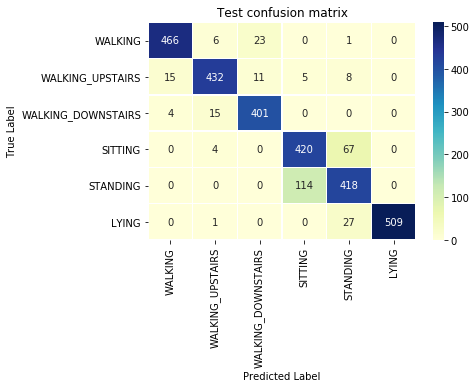

In [30]:
sns.heatmap(frame_confusion, annot = True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Test confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CNN

In [21]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(Conv1D(32, kernel_size=(3),
                 activation='relu',
                 input_shape=(timesteps, input_dim)))
model.add(Conv1D(64, (3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
# Adding a dropout layer
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 124, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               508032    
___________________________

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 5s 734us/step - loss: 0.4459 - acc: 0.8256 - val_loss: 0.6001 - val_acc: 0.8504
Epoch 2/30
7352/7352 [==============================] - 5s 697us/step - loss: 0.1729 - acc: 0.9335 - val_loss: 0.5595 - val_acc: 0.8809
Epoch 3/30
7352/7352 [==============================] - 7s 931us/step - loss: 0.1384 - acc: 0.9463 - val_loss: 0.5038 - val_acc: 0.8918
Epoch 4/30
7352/7352 [==============================] - 5s 744us/step - loss: 0.1313 - acc: 0.9479 - val_loss: 0.5545 - val_acc: 0.9043
Epoch 5/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.1300 - acc: 0.9487 - val_loss: 0.5064 - val_acc: 0.8945
Epoch 6/30
7352/7352 [==============================] - 6s 799us/step - loss: 0.1251 - acc: 0.9501 - val_loss: 0.5968 - val_acc: 0.9019
Epoch 7/30
7352/7352 [==============================] - 5s 669us/step - loss: 0.1130 - acc

In [27]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  0      383       105        0                   0   
STANDING                 1       64       461        2                   0   
WALKING                  0        0         0      490                   4   
WALKING_DOWNSTAIRS       0        0         0       95                 295   
WALKING_UPSTAIRS         0        0         0       37                  25   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            3  
STANDING                           4  
WALKING                            2  
WALKING_DOWNSTAIRS                30  
WALKING_UPSTAIRS                 409  


In [28]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 800us/step


In [29]:
score

[1.9993040630948475, 0.8734306073973532]

In [24]:
model = Sequential()
# Configuring the parameters
model.add(Conv1D(64, kernel_size=(3),
                 activation='relu',
                 input_shape=(timesteps, input_dim)))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64, (3), activation='relu'))
# Adding a dropout layer
model.add(Dropout(0.25))
model.add(Flatten())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 61, 64)            12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 61, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3904)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 23430     
Total params: 37,574
Trainable params: 37,574
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 4s 527us/step - loss: 0.3983 - acc: 0.8419 - val_loss: 0.5101 - val_acc: 0.8711
Epoch 2/30
7352/7352 [==============================] - 4s 488us/step - loss: 0.1480 - acc: 0.9419 - val_loss: 0.5742 - val_acc: 0.8911
Epoch 3/30
7352/7352 [==============================] - 4s 490us/step - loss: 0.1239 - acc: 0.9475 - val_loss: 0.4594 - val_acc: 0.8955
Epoch 4/30
7352/7352 [==============================] - 4s 490us/step - loss: 0.1093 - acc: 0.9554 - val_loss: 0.5108 - val_acc: 0.9111
Epoch 5/30
7352/7352 [==============================] - 4s 490us/step - loss: 0.0999 - acc: 0.9570 - val_loss: 0.5746 - val_acc: 0.8948
Epoch 6/30
7352/7352 [==============================] - 4s 491us/step - loss: 0.0921 - acc: 0.9588 - val_loss: 0.5230 - val_acc: 0.8996
Epoch 7/30
7352/7352 [==============================] - 4s 493us/step - loss: 0.0870 - acc: 0.9634 - val_loss: 0.4725 - val_acc: 0.9175


In [27]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  1      435        47        1                   0   
STANDING                 0      107       417        3                   1   
WALKING                  0        0         0      453                  42   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         0       16                  47   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            7  
STANDING                           4  
WALKING                            1  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 408  


In [28]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 0s 115us/step


In [29]:
score

[0.7338126605104306, 0.9056667797760435]

In [62]:
model = Sequential()
# Configuring the parameters
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(None,32,input_dim)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.8)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.8))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_61 (TimeDis (None, None, 30, 128)     3584      
_________________________________________________________________
time_distributed_62 (TimeDis (None, None, 15, 128)     0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, None, 13, 64)      24640     
_________________________________________________________________
time_distributed_64 (TimeDis (None, None, 13, 64)      0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_66 (TimeDis (None, None, 384)         0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               262656    
__________

In [63]:
model.fit(trainX,
          Y_train,
          batch_size=batch_size,
          validation_data=(testX, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 16s 2ms/step - loss: 0.6793 - acc: 0.7058 - val_loss: 0.5768 - val_acc: 0.7696
Epoch 2/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.2548 - acc: 0.9089 - val_loss: 0.3187 - val_acc: 0.8880
Epoch 3/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1646 - acc: 0.9369 - val_loss: 0.3886 - val_acc: 0.8789
Epoch 4/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1519 - acc: 0.9407 - val_loss: 0.3131 - val_acc: 0.8785
Epoch 5/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1476 - acc: 0.9402 - val_loss: 0.3329 - val_acc: 0.9033
Epoch 6/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1232 - acc: 0.9484 - val_loss: 0.2871 - val_acc: 0.9101
Epoch 7/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1487 - acc: 0.9404 - val_loss: 0.3046 - val_acc: 0.9080
Epoch 8

## CNN + Test Sharpening

In [1]:
import numpy as np
from scipy import ndimage
dir_path = './UCI HAR Dataset/'

In [2]:
def load_x(train_or_test):
    global dir_path
    if train_or_test is "train":
        x_path = dir_path + 'train/X_train.txt'
    elif train_or_test is "test":
        x_path = dir_path + 'test/X_test.txt'

    with open(x_path) as f:
        container = f.readlines()

    result = []
    for line in container:
        tmp1 = line.strip()
        tmp2 = tmp1.replace('  ', ' ')     # removes inconsistent blank spaces
        tmp_ary = list(map(float, tmp2.split(' ')))
        result.append(tmp_ary)
    return np.array(result)

In [3]:
def load_y(train_or_test):
    global dir_path
    if train_or_test is "train":
        y_path = dir_path + 'train/y_train.txt'
    elif train_or_test is "test":
        y_path = dir_path + 'test/y_test.txt'

    with open(y_path) as f:
        container = f.readlines()

    result = []
    for line in container:
        num_str = line.strip()
        result.append(int(num_str))
    return np.array(result)

In [4]:
def sharpen(x_test, sigma, alpha):
    r = x_test.shape[0]
    c = x_test.shape[1]
    container = np.empty((r, c))
    i = 0

    for row in x_test:
        test = np.array([row])
        blurred = ndimage.gaussian_filter(test, sigma)
        sharpened = test + alpha * (test - blurred)
        container[i] = sharpened
        i = i + 1
    return container

In [5]:
import os
import numpy as np
import random
from numpy.random import seed
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import keras.backend as K

Using TensorFlow backend.


### Static Features

In [187]:
X_train_all = load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

X_test_all = load_x("test")
y_test_all = load_y("test")

In [188]:
X_train_all.shape

(7352, 561)

In [189]:
static_1 = np.where(y_train_all == 4)[0]
static_2 = np.where(y_train_all == 5)[0]
static_3 = np.where(y_train_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

In [190]:
r = random.random()
random.shuffle(static_list, lambda: r)

In [191]:
static = np.array(static_list)

X_train = X_train_all[static]
y_train = y_train_all[static]

In [192]:
y_train  = y_train - 4

In [193]:
print("\n+++ DATA STATISTICS +++\n")
print("train_static shape: ", X_train.shape)


+++ DATA STATISTICS +++

train_static shape:  (4067, 561)


In [194]:
static_1 = np.where(y_test_all == 4)[0]
static_2 = np.where(y_test_all == 5)[0]
static_3 = np.where(y_test_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])

In [195]:
X_test = X_test_all[static]
y_test = y_test_all[static]

In [196]:
y_test  = y_test - 4

In [197]:
print("test_static shape: ", X_test.shape)

test_static shape:  (1560, 561)


In [198]:
n_classes = 3

In [18]:
# Convert to one hot encoding vector
y_train_static_oh = np.eye(n_classes)[y_train]

In [19]:
seed(2017)
model = Sequential()
model.add(Conv1D(30, 3, input_shape=(561, 1), activation='relu'))
model.add(Conv1D(50, 3, activation='relu'))
model.add(Conv1D(100, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.50))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 559, 30)           120       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 557, 50)           4550      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 555, 100)          15100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 55500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 166503    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
Total params: 186,273
Trainable params: 186,273
Non-trainable params: 0
_________________________________________________________________
None

In [21]:
new_dir = 'model/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
fpath = new_dir + 'weights.{epoch:02d}-{val_acc:.2f}.hdf5'

In [22]:
cp_cb = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [23]:
model.fit(np.expand_dims(X_train, axis=2), y_train_static_oh,
          batch_size=32, epochs=100, verbose=2, validation_split=0.2, callbacks=[cp_cb])

Instructions for updating:
Use tf.cast instead.
Train on 3253 samples, validate on 814 samples
Epoch 1/100
 - 5s - loss: 0.3092 - acc: 0.4270 - val_loss: 0.1336 - val_acc: 0.9312

Epoch 00001: val_loss improved from inf to 0.13363, saving model to model/weights.01-0.93.hdf5
Epoch 2/100
 - 5s - loss: 0.2576 - acc: 0.5192 - val_loss: 0.0739 - val_acc: 0.9570

Epoch 00002: val_loss improved from 0.13363 to 0.07388, saving model to model/weights.02-0.96.hdf5
Epoch 3/100
 - 4s - loss: 0.2457 - acc: 0.5327 - val_loss: 0.0743 - val_acc: 0.9595

Epoch 00003: val_loss did not improve from 0.07388
Epoch 4/100
 - 5s - loss: 0.2502 - acc: 0.5143 - val_loss: 0.0770 - val_acc: 0.9582

Epoch 00004: val_loss did not improve from 0.07388
Epoch 5/100
 - 5s - loss: 0.2428 - acc: 0.5337 - val_loss: 0.0693 - val_acc: 0.9656

Epoch 00005: val_loss improved from 0.07388 to 0.06925, saving model to model/weights.05-0.97.hdf5
Epoch 6/100
 - 5s - loss: 0.2376 - acc: 0.5413 - val_loss: 0.0626 - val_acc: 0.9595



 - 5s - loss: 0.2369 - acc: 0.5217 - val_loss: 0.0624 - val_acc: 0.9742

Epoch 00057: val_loss did not improve from 0.05940
Epoch 58/100
 - 5s - loss: 0.2299 - acc: 0.5460 - val_loss: 0.0664 - val_acc: 0.9693

Epoch 00058: val_loss did not improve from 0.05940
Epoch 59/100
 - 4s - loss: 0.2320 - acc: 0.5358 - val_loss: 0.0640 - val_acc: 0.9705

Epoch 00059: val_loss did not improve from 0.05940
Epoch 60/100
 - 5s - loss: 0.2270 - acc: 0.5475 - val_loss: 0.0627 - val_acc: 0.9681

Epoch 00060: val_loss did not improve from 0.05940
Epoch 61/100
 - 7s - loss: 0.2278 - acc: 0.5420 - val_loss: 0.0645 - val_acc: 0.9631

Epoch 00061: val_loss did not improve from 0.05940
Epoch 62/100
 - 5s - loss: 0.2275 - acc: 0.5453 - val_loss: 0.0764 - val_acc: 0.9644

Epoch 00062: val_loss did not improve from 0.05940
Epoch 63/100
 - 4s - loss: 0.2270 - acc: 0.5533 - val_loss: 0.0660 - val_acc: 0.9668

Epoch 00063: val_loss did not improve from 0.05940
Epoch 64/100
 - 4s - loss: 0.2320 - acc: 0.5340 - val_

In [24]:
del model
K.clear_session()

#### Rename highest epoch weight file to static.hdf5

In [33]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [34]:
model_path = "model/static.hdf5"
model = load_model(model_path)

In [35]:
pred_train = model.predict(np.expand_dims(X_train, axis=2), batch_size=32)
print("------ TRAIN ACCURACY ------")
print(accuracy_score(y_train, np.argmax(pred_train, axis=1)))
print(confusion_matrix(y_train, np.argmax(pred_train, axis=1)))

------ TRAIN ACCURACY ------
0.9916400295057782
[[1275   11    0]
 [  23 1351    0]
 [   0    0 1407]]


In [36]:
pred_test = model.predict(np.expand_dims(X_test, axis=2), batch_size=32)
print("------ TEST ACCURACY ------")
print(accuracy_score(y_test, np.argmax(pred_test, axis=1)))
print(confusion_matrix(y_test, np.argmax(pred_test, axis=1)))

------ TEST ACCURACY ------
0.9628205128205128
[[447  44   0]
 [ 14 518   0]
 [  0   0 537]]


### Dynamic Features

In [165]:
import os
import numpy as np
import random
from numpy.random import seed
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import keras.backend as K

In [166]:
X_train_all = load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

In [167]:
X_test_all = load_x("test")
y_test_all = load_y("test")

In [168]:
dynamic_1 = np.where(y_train_all == 1)[0]
dynamic_2 = np.where(y_train_all == 2)[0]
dynamic_3 = np.where(y_train_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

In [169]:
r = random.random()
random.shuffle(dynamic_list, lambda: r)

In [170]:
dynamic = np.array(dynamic_list)

X_train = X_train_all[dynamic]
y_train = y_train_all[dynamic]

In [171]:
y_train  = y_train - 1

In [172]:
dynamic_1 = np.where(y_test_all == 1)[0]
dynamic_2 = np.where(y_test_all == 2)[0]
dynamic_3 = np.where(y_test_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])

In [173]:
X_test = X_test_all[dynamic]
y_test = y_test_all[dynamic]

In [174]:
y_test  = y_test - 1

In [175]:
print("test_dynamic shape: ", X_test.shape)

test_dynamic shape:  (1387, 561)


In [48]:
n_classes = 3

In [49]:
y_train_dynamic_oh = np.eye(n_classes)[y_train]

In [50]:
seed(2017)
model = Sequential()
model.add(Conv1D(100, 3, input_shape=(561, 1), activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.5))

In [51]:
adam = Adam(lr=0.0004, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

In [52]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 559, 100)          400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 186, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 55803     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
Total params: 56,203
Trainable params: 56,203
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
new_dir = 'model/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
fpath = new_dir + 'weights.{epoch:02d}-{val_acc:.2f}.hdf5'

In [54]:
cp_cb = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [55]:
model.fit(np.expand_dims(X_train, axis=2), y_train_dynamic_oh,
          batch_size=32, epochs=50, verbose=2, validation_split=0.2,
          callbacks=[cp_cb])

Train on 2628 samples, validate on 657 samples
Epoch 1/50
 - 1s - loss: 0.2815 - acc: 0.4939 - val_loss: 0.1275 - val_acc: 0.8219

Epoch 00001: val_loss improved from inf to 0.12753, saving model to model/weights.01-0.82.hdf5
Epoch 2/50
 - 1s - loss: 0.2479 - acc: 0.5396 - val_loss: 0.1106 - val_acc: 0.9072

Epoch 00002: val_loss improved from 0.12753 to 0.11060, saving model to model/weights.02-0.91.hdf5
Epoch 3/50
 - 1s - loss: 0.2416 - acc: 0.5464 - val_loss: 0.0855 - val_acc: 0.9833

Epoch 00003: val_loss improved from 0.11060 to 0.08546, saving model to model/weights.03-0.98.hdf5
Epoch 4/50
 - 1s - loss: 0.2394 - acc: 0.5483 - val_loss: 0.0953 - val_acc: 0.9787

Epoch 00004: val_loss did not improve from 0.08546
Epoch 5/50
 - 1s - loss: 0.2355 - acc: 0.5506 - val_loss: 0.0924 - val_acc: 0.9680

Epoch 00005: val_loss did not improve from 0.08546
Epoch 6/50
 - 1s - loss: 0.2367 - acc: 0.5548 - val_loss: 0.0864 - val_acc: 0.9802

Epoch 00006: val_loss did not improve from 0.08546
Epo

In [56]:
del model
K.clear_session()

#### Rename highest epoch weight file to dynamic.hdf5

In [57]:
model_path = "model/dynamic.hdf5"
model = load_model(model_path)

In [58]:
pred_train = model.predict(np.expand_dims(X_train, axis=2), batch_size=32)
print("------ TRAIN ACCURACY ------")
print(accuracy_score(y_train, np.argmax(pred_train, axis=1)))
print(confusion_matrix(y_train, np.argmax(pred_train, axis=1)))

------ TRAIN ACCURACY ------
0.9933028919330289
[[1219    6    1]
 [   0 1071    2]
 [   0   13  973]]


In [59]:
pred_test = model.predict(np.expand_dims(X_test, axis=2), batch_size=32)
print("------ TEST ACCURACY ------")
print(accuracy_score(y_test, np.argmax(pred_test, axis=1)))
print(confusion_matrix(y_test, np.argmax(pred_test, axis=1)))

------ TEST ACCURACY ------
0.9776496034607065
[[493   1   2]
 [ 12 459   0]
 [  3  13 404]]


### Static Sharpening

In [60]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import random
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [138]:
accuracy_list = []
alpha = np.arange(0.01, 0.31, 0.01)
sigma = np.arange(5, 10, 1)
def display_output_x(title_str, X, y):

    # Load static HAR model
    model_path = "model/static.hdf5"
    model = load_model(model_path)

    print("\n=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===")
    print("===         Test Data: {} Half         ===\n".format(title_str))

    pred_dyna_raw = model.predict(np.expand_dims(X, axis=2), batch_size=32)
    print("---------------------------------")
    print("       NO SHARPEN ACCURACY       ")
    print("---------------------------------")
    print(accuracy_score(y, np.argmax(pred_dyna_raw, axis=1)))
    print(confusion_matrix(y, np.argmax(pred_dyna_raw, axis=1)))

    alpha = np.arange(0.01, 0.31, 0.01)
    sigma = np.arange(5, 10, 1)
    
    for s in sigma:
        new_list = []
        for a in alpha:
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
            X_test_sharpen = sharpen(X, s, a)
            pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
            new_list.append(accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
        list_new = np.array(new_list)    
        accuracy_list.append(alpha[np.argmax(new_list)])
    
    print("\n---------------------------------")
    print("       SHARPENED  ACCURACY       ")
    print("---------------------------------")
    s = 5
    for a in accuracy_list:
        X_test_sharpen = sharpen(X, s, a)
        pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
        print(">>> sigma={}, alpha={:.2f}".format(s, a))
        print(accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
        print(confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)))
        s = s + 1

In [127]:
X_test = load_x("test")
y_test = load_y("test")

In [128]:
seed = 818

In [129]:
random.seed(seed)
stat_1 = list(np.where(y_test == 4)[0])
temp = int(len(stat_1) * 0.5)
stat_1_first = random.sample(stat_1, temp)
stat_1_second = list(set(stat_1) - set(stat_1_first))

In [130]:
random.seed(seed)
stat_2 = list(np.where(y_test == 5)[0])
stat_2_first = random.sample(stat_2, int(len(stat_2) * 0.5))
stat_2_second = list(set(stat_2) - set(stat_2_first))

In [131]:
random.seed(seed)
stat_3 = list(np.where(y_test == 6)[0])
stat_3_first = random.sample(stat_3, int(len(stat_3) * 0.5))
stat_3_second = list(set(stat_3) - set(stat_3_first))

In [132]:
static_first = np.concatenate([stat_1_first, stat_2_first, stat_3_first])
static_second = np.concatenate([stat_1_second, stat_2_second, stat_3_second])

In [133]:
X_test_first = X_test[static_first]
y_test_first = y_test[static_first] - 4   # Convert (4, 5, 6) labels to (0, 1, 2)
print("test_static_first shape: ", X_test_first.shape)

test_static_first shape:  (779, 561)


In [134]:
X_test_second = X_test[static_second]
y_test_second = y_test[static_second] - 4   # Convert (4, 5, 6) labels to (0, 1, 2)
print("test_static_second shape: ", X_test_second.shape)

test_static_second shape:  (781, 561)


In [135]:
display_output_x("First", X_test_first, y_test_first)


=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: First Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.9576379974326059
[[219  26   0]
 [  7 259   0]
 [  0   0 268]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
>>> sigma=5, alpha=0.18
0.9640564826700898
[[228  17   0]
 [ 11 255   0]
 [  0   0 268]]
>>> sigma=6, alpha=0.15
0.9640564826700898
[[228  17   0]
 [ 11 255   0]
 [  0   0 268]]
>>> sigma=7, alpha=0.14
0.9640564826700898
[[228  17   0]
 [ 11 255   0]
 [  0   0 268]]
>>> sigma=8, alpha=0.14
0.9640564826700898
[[228  17   0]
 [ 11 255   0]
 [  0   0 268]]
>>> sigma=9, alpha=0.14
0.9640564826700898
[[228  17   0]
 [ 11 255   0]
 [  0   0 268]]


In [139]:
display_output_x("Second", X_test_second, y_test_second)


=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: Second Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.967989756722151
[[228  18   0]
 [  7 259   0]
 [  0   0 269]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
>>> sigma=5, alpha=0.01
0.9641485275288092
[[228  18   0]
 [ 10 256   0]
 [  0   0 269]]
>>> sigma=6, alpha=0.01
0.9641485275288092
[[228  18   0]
 [ 10 256   0]
 [  0   0 269]]
>>> sigma=7, alpha=0.15
0.9654289372599232
[[232  14   0]
 [ 13 253   0]
 [  0   0 269]]
>>> sigma=8, alpha=0.14
0.9654289372599232
[[232  14   0]
 [ 13 253   0]
 [  0   0 269]]
>>> sigma=9, alpha=0.01
0.9641485275288092
[[228  18   0]
 [ 10 256   0]
 [  0   0 269]]


#### By cross checking both the sets we can conclude that s = 8 and alpha = 0.14

### Dynamic Sharpening

In [136]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import random

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [141]:
def display_output_x(title_str, X, y):

    # Load static HAR model
    model_path = "model/dynamic.hdf5"
    model = load_model(model_path)

    print("\n=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===")
    print("===         Test Data: {} Half         ===\n".format(title_str))

    pred_dyna_raw = model.predict(np.expand_dims(X, axis=2), batch_size=32)
    print("---------------------------------")
    print("       NO SHARPEN ACCURACY       ")
    print("---------------------------------")
    print(accuracy_score(y, np.argmax(pred_dyna_raw, axis=1)))
    print(confusion_matrix(y, np.argmax(pred_dyna_raw, axis=1)))

    alpha = np.arange(0.05, 2.55, 0.05)
    sigma = np.arange(5, 10, 1)
    accuracy_list = []
    for s in sigma:
        new_list = []
        for a in alpha:
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
            X_test_sharpen = sharpen(X, s, a)
            pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
            new_list.append(accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
        list_new = np.array(new_list)    
        accuracy_list.append(alpha[np.argmax(new_list)])
    
    print("\n---------------------------------")
    print("       SHARPENED  ACCURACY       ")
    print("---------------------------------")
    s = 5
    for a in accuracy_list:
        X_test_sharpen = sharpen(X, s, a)
        pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
        print(">>> sigma={}, alpha={:.2f}".format(s, a))
        print(accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
        print(confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)))
        s = s + 1

In [142]:
X_test = load_x("test")
y_test = load_y("test")

In [143]:
seed = 2017

In [144]:
random.seed(seed)
dyna_1 = list(np.where(y_test == 1)[0])
dyna_1_first = random.sample(dyna_1, int(len(dyna_1) * 0.5))
dyna_1_second = list(set(dyna_1) - set(dyna_1_first))

In [145]:
random.seed(seed)
dyna_2 = list(np.where(y_test == 2)[0])
dyna_2_first = random.sample(dyna_2, int(len(dyna_2) * 0.5))
dyna_2_second = list(set(dyna_2) - set(dyna_2_first))

In [146]:
random.seed(seed)
dyna_3 = list(np.where(y_test == 3)[0])
dyna_3_first = random.sample(dyna_3, int(len(dyna_3) * 0.5))
dyna_3_second = list(set(dyna_3) - set(dyna_3_first))

In [147]:
dynamic_first = np.concatenate([dyna_1_first, dyna_2_first, dyna_3_first])
dynamic_second = np.concatenate([dyna_1_second, dyna_2_second, dyna_3_second])

In [149]:
X_test_first = X_test[dynamic_first]
y_test_first = y_test[dynamic_first] - 1   # Convert (1, 2, 3) labels to (0, 1, 2)
print("test_dynamic_first shape: ", X_test_first.shape)

test_dynamic_first shape:  (693, 561)


In [150]:
X_test_second = X_test[dynamic_second]
y_test_second = y_test[dynamic_second] - 1  
# Convert (1, 2, 3) labels to (0, 1, 2)
print("test_dynamic_second shape: ", X_test_second.shape)

test_dynamic_second shape:  (694, 561)


In [151]:
display_output_x("First", X_test_first, y_test_first)


=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: First Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.9841269841269841
[[247   1   0]
 [  5 230   0]
 [  0   5 205]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
>>> sigma=5, alpha=0.05
0.9855699855699855
[[247   1   0]
 [  5 230   0]
 [  0   4 206]]
>>> sigma=6, alpha=0.05
0.9841269841269841
[[247   1   0]
 [  6 229   0]
 [  0   4 206]]
>>> sigma=7, alpha=0.05
0.9841269841269841
[[247   1   0]
 [  6 229   0]
 [  0   4 206]]
>>> sigma=8, alpha=0.05
0.9841269841269841
[[247   1   0]
 [  6 229   0]
 [  0   4 206]]
>>> sigma=9, alpha=0.05
0.9841269841269841
[[247   1   0]
 [  6 229   0]
 [  0   4 206]]


In [152]:
display_output_x("Second", X_test_second, y_test_second)


=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: Second Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.9711815561959655
[[246   0   2]
 [  7 229   0]
 [  3   8 199]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
>>> sigma=5, alpha=0.10
0.9697406340057637
[[244   1   3]
 [  7 229   0]
 [  2   8 200]]
>>> sigma=6, alpha=0.10
0.9697406340057637
[[244   1   3]
 [  7 229   0]
 [  2   8 200]]
>>> sigma=7, alpha=0.05
0.9697406340057637
[[245   0   3]
 [  7 229   0]
 [  3   8 199]]
>>> sigma=8, alpha=0.05
0.9697406340057637
[[245   0   3]
 [  7 229   0]
 [  3   8 199]]
>>> sigma=9, alpha=0.05
0.9697406340057637
[[245   0   3]
 [  7 229   0]
 [  3   8 199]]


#### By cross checking both the sets we can conclude that s = 8 and alpha = 0.04

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
def display_output_dyna(X, y,s,a):

    # Load static HAR model
    model_path = "model/dynamic.hdf5"
    model = load_model(model_path)
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
    X_test_sharpen = sharpen(X, s, a)
    pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
    print('------------')
    print('Dynamic')
    print('------------')
    print("Accuracy : ",accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
    label = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]
    frame_confusion = pd.DataFrame(confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)), 
                                   index = label, columns = label)

    sns.heatmap(frame_confusion, annot = True, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.title("Test confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

------------
Dynamic
------------
Accuracy :  0.976928622927181


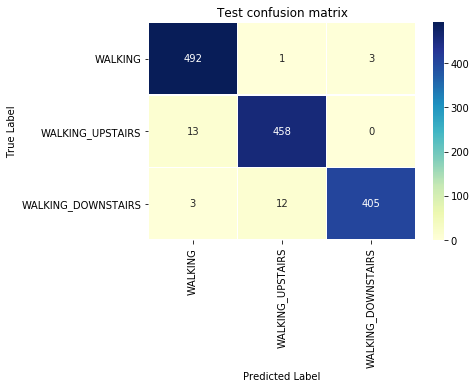

In [186]:
display_output_dyna( X_test, y_test,8,0.04 )

In [203]:
def display_output_stat(X, y,s,a):

    # Load static HAR model
    model_path = "model/static.hdf5"
    model = load_model(model_path)
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
    X_test_sharpen = sharpen(X, s, a)
    pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
    print('------------')
    print('Static')
    print('------------')
    print("Accuracy : ",accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
    label = ["SITTING", "STANDING", "LYING"]
    frame_confusion = pd.DataFrame(confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)), 
                                   index = label, columns = label)

    sns.heatmap(frame_confusion, annot = True, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.title("Test confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

------------
Static
------------
Accuracy :  0.9647435897435898


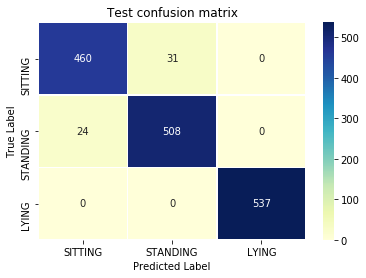

In [204]:
display_output_stat( X_test, y_test,8,0.14 )

In [31]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Hyper-parameters (units)","Hyper-parameters (Drop-outs)" ,"Accuracy"]
x.add_row(["LSTM", 64, "D1 - 0.233", 0.9199])
x.add_row(["LSTM 2-layers", 64, "D1 - 0.425, D2 - 0.233", 0.8979])
print(x)

+---------------+--------------------------+------------------------------+----------+
|     Model     | Hyper-parameters (units) | Hyper-parameters (Drop-outs) | Accuracy |
+---------------+--------------------------+------------------------------+----------+
|      LSTM     |            64            |          D1 - 0.233          |  0.9199  |
| LSTM 2-layers |            64            |    D1 - 0.425, D2 - 0.233    |  0.8979  |
+---------------+--------------------------+------------------------------+----------+


In [205]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Accuracy"]
x.add_row(["CNN + CNN + MP + DO + Dense",  0.9199])
x.add_row(["CNN + MP + DO + Dense", 0.9056])
x.add_row(["TimeDistributed(CNN + MP + CNN  + MP) + LSTM + Dense", 0.8992])
print(x)

+------------------------------------------------------+----------+
|                        Model                         | Accuracy |
+------------------------------------------------------+----------+
|             CNN + CNN + MP + DO + Dense              |  0.9199  |
|                CNN + MP + DO + Dense                 |  0.9056  |
| TimeDistributed(CNN + MP + CNN  + MP) + LSTM + Dense |  0.8992  |
+------------------------------------------------------+----------+


In [206]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Split","Sigma", "Alpha","Accuracy"]
x.add_row(["CNN + Test Sharping", "Dynamic", 8 , 0.04 , 0.9796])
x.add_row(["CNN + Test Sharping", "Static", 8, 0.14, 0.9647])
print(x)

+---------------------+---------+-------+-------+----------+
|        Model        |  Split  | Sigma | Alpha | Accuracy |
+---------------------+---------+-------+-------+----------+
| CNN + Test Sharping | Dynamic |   8   |  0.04 |  0.9796  |
| CNN + Test Sharping |  Static |   8   |  0.14 |  0.9647  |
+---------------------+---------+-------+-------+----------+


## Step followed in case study

- ____Step 1____ : Fetched data from raw dataset.
 - ____Step 2____ : Applied dataset on various LSTM Architectures.
 - ____Step 3____ : Applied dataset on various CNN Architectures. 
 - ____Step 4____ : Since LSTM and CNN have a cap of 92%, split dataset features into 2 categories static and dynamic.
 - ____Step 5____ : Applied CNN on 2 seperate datasets and saved their model weights in files static.hdf5 and dynamic.hdf5.
 - ____Step 6____ : Again split the categories into subsets of 2 for each category.
 - ____Step 7____ : The above method is helpful in determining sigma and alpha values for sharpening.
 - ____Step 7____ : Finally converged the model into 2 seperate model, one predicting static and other dynamic.
 
 - ____Observations____ : In the following case study, static gave an accuracy of 96.47% and dynamic an accuracy of 97.96%.

## References

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5949027/
https://github.com/heeryoncho/sensors2018cnnhar